# Laboratory 6: The Variational Auto-Encoder

Authors: Junjie Chen, Pavlo Poliuha and Pablo Mollá

### Introduction

The VAE that we will develop is based on the following generative story:

* $z\sim p(z)$
* $x \sim p(x|z;θ)$

where the latent representations $z$ take values in $\mathbb{R}^n$. The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent. We fix the mean and variance of each coordinate to 0 and 1, respectively. The conditional distribution $p(x|z;θ)$ is parameterized by a neural network: it is the decoder! The generated pixels $x$ are independent Gaussians with a fixed variance.

$\textcolor{red}{Note}$ : This kind of VAE will be quite bad at generating MNIST picture. Therefore, when you do you experiments, you should both generate picture and display the mean parameters of the output distributions. This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.

Although the decoder is similar to the auto-encoder decoder, the encoder is different: it must return two tensors, the tensor of means and the tensor of variances. As the variance of a Gaussian distribution is constrained to be strictly positive, it is usual to instead return the log-variance (or log squared variance), which is unconstrained. If you exponentiate the log-variance, you get the variance which will be strictly positive as the exponential function only returns positive values.

Similarly to the auto-encoder, there are several hyperparameters you can try to tune. However, for the VAE I strongly advise you to:
* Set the latent space dim to 2
* Use [gradient clipping](https://pytorch-org.translate.goog/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html?_x_tr_sl=en&_x_tr_tl=fr&_x_tr_hl=fr&_x_tr_pto=sc) (bound the gradient)


In [20]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import matplotlib.cm as cm

### The Encoder

The `VAEEncoder` class defines the encoder part of the VAE, which is responsible for transforming the input data into a latent space representation by estimating the parameters of the latent variable's distribution. The class is defined as follows:

- **Initialization (`__init__`):**
  - `dim_input`: Dimension of the input data.
  - `dim_middle`: Dimension of the intermediate layer.
  - `dim_latent`: Dimension of the latent space (i.e., the output of the encoder).

The encoder consists of the following layers:
  - `self.fc1`: A fully connected linear layer that maps the input data to the intermediate layer.
  - `self.fc_mu`: A fully connected linear layer that maps the output of `self.fc1` to the mean $\mu$ of the latent space distribution.
  - `self.fc_log_var`: A fully connected linear layer that maps the output of `self.fc1` to the logarithm of the variance $\log \sigma^2$ of the latent space distribution. This ensures that the variance is always positive.

- **Forward Pass (`forward`):**
  - The input $x$ is first passed through `self.fc1` and a ReLU activation function to introduce non-linearity.
  - The result, $h$, is then passed through `self.fc_mu` to produce the mean $\mu$ and through `self.fc_log_var` to produce the log variance $\log \sigma^2$.
  - The output of the forward pass is the tuple $(\mu, \log \sigma^2)$, representing the parameters of the Gaussian distribution of the latent variables where:

    - $\mu = \text{{self.fc\_mu}}(h)$

    - $\log \sigma^2 = \text{{self.fc\_log\_var}}(h)$


### The Decoder

The `VAEDecoder` class defines the decoder part of the VAE, which reconstructs the input data from the latent space representation. The class is structured as follows:

- **Initialization (`__init__`):**
  - `dim_latent`: Dimension of the latent space (i.e., the input to the decoder).
  - `dim_middle`: Dimension of the intermediate layer.
  - `dim_output`: Dimension of the reconstructed output, which matches the dimension of the original input data.

The decoder consists of the following layers:
  - `self.fc2`: A fully connected linear layer that maps the latent variables to the intermediate layer.
  - `self.fc3`: A fully connected linear layer that maps the output of `self.fc2` to the final output layer.

- **Forward Pass (`forward`):**
  - The latent variable $z$ is first passed through `self.fc2` and a ReLU activation function.
  - The result is then passed through `self.fc3`, and a sigmoid activation function is applied to the output. The sigmoid function ensures that the output values are in the range [0,1], which is particularly useful when dealing with binary cross-entropy as a loss function.
  
    - $h = \text{{ReLU}}(\text{{self.fc2}}(z))$
    - $x_{\text{{reconstructed}}} = \sigma_{sigmoid}(\text{{self.fc3}}(h))$



In Variational Autoencoders (VAEs), activation functions like ReLU (Rectified Linear Unit) and Sigmoid play crucial roles in defining the behavior and performance of the neural networks used for the encoder and decoder components.

### ReLU (Rectified Linear Unit)

$\textbf{Definition}$: 

- ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero. It introduces non-linearity into the neural network without affecting the scales of positive numbers and without saturating in the positive direction. This characteristic makes it very popular in deep learning models because it helps reduce the likelihood of the vanishing gradient problem.
The ReLU function is defined as follows:

$$ \text{ReLU}(x) = \max(0, x), \forall x \in \mathrm{R} $$

$\textbf{Usage in VAEs}$: 

- In VAEs, ReLU is commonly used in the hidden layers of both the encoder and the decoder networks. Its primary role is to allow for non-linear transformations of the inputs, helping the networks learn more complex patterns. The non-saturating nature of ReLU is particularly useful for deep networks, contributing to faster convergence during training compared to traditional sigmoid functions.

### Sigmoid

$\textbf{Definition}$: The Sigmoid function is a smooth, S-shaped function that outputs a value between 0 and 1. This bounded nature makes it suitable for models where a probability interpretation is needed or when the output needs to be mapped to a range such as [0, 1], which is often the case in classification problems or when dealing with binary data. The ReLU function is defined as follows:

$$ \sigma(x) = \frac{1}{1 + e^{-x}}, \forall x \in \mathrm{R} $$

$\textbf{Usage in VAEs}$: In VAEs, the Sigmoid function is commonly used in the output layer of the decoder when the input data comprises features normalized between 0 and 1, such as pixel values of images. The sigmoid function ensures that the outputs of the decoder are constrained to this range, which is essential for effectively reconstructing input data that has been normalized in this way.
    


### Classes VAEEncoder & VAEDecoder

In [21]:
class VAEEncoder(nn.Module):
    def __init__(self, dim_input,dim_middle, dim_latent):
        super().__init__()
        # Directly connect input to the latent space parameters (mean and log variance)
        self.fc1 = nn.Linear(dim_input, dim_middle)
        self.fc_mu = nn.Linear(dim_middle, dim_latent)  # Input to latent space mean
        self.fc_log_var = nn.Linear(dim_middle, dim_latent)  # Input to latent space log variance

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var
        
class VAEDecoder(nn.Module):
    def __init__(self, dim_latent, dim_middle,dim_output):
        super().__init__()
        # Directly connect latent space to output
        self.fc2 = nn.Linear(dim_latent, dim_middle)
        self.fc3 = nn.Linear(dim_middle, dim_output)

    def forward(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

To compute the training loss, you must compute two terms:
* A Monte-Carlo estimation of the reconstruction loss (you can start considering sampling only one z)
* The KL divergence between the distributions computed by the encoder and the prior

For the reconstruction loss, you can use the mean square error loss.

To sample values, you can use the reparameterization trick as follows: 
```
e = torch.normal(0, 1., mu.shape)
z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))
```

For the formula of the $KL(q(z|x)|| p(z))$ you should have it from the exercise we did during the lecture. You can also check appendix of the [original paper](https://arxiv.org/pdf/1312.6114.pdf) 

You have in the following to implements:
* The training loop
* The two losses
* Choose which architecture for encoder and decoder

When training a Variational Autoencoder (VAE), the loss function is comprised of two main components:

- $\textcolor{red}{\text{The reconstruction loss}}$
- $\textcolor{blue}{\text{The Kullback-Leibler (KL) divergence}}$. 

These components reflect the dual objectives of the VAE, which are to both accurately reconstruct the input data and ensure that the learned latent variable distribution closely approximates the prior distribution.

### Monte-Carlo Estimation of the Reconstruction Loss

The $\textcolor{red}{\text{reconstruction loss}}$ measures how effectively the VAE can reconstruct the input data from the latent variables. Since the exact evaluation of the loss over the continuous latent space is infeasible, a Monte-Carlo estimation is used, which approximates the expectation by sampling. For simplicity, we often start by sampling only one latent variable $z$ per input data point $x$:


$$\text{Reconstruction Loss} \approx \frac{1}{N} \sum_{i=1}^N \log p_\theta(x^{(i)} | z^{(i)}), \quad z^{(i)} \sim q_\phi(z | x^{(i)})$$

Here, $N$ is the number of samples (data points), $x^{(i)}$ is the $i$-th data point, and $z^{(i)}$ is a latent sample drawn from the encoder's distribution $q_\phi(z | x^{(i)})$ parameterized by $\phi$. The decoder's probability $p_\theta(x | z)$, parameterized by $\theta$, gives the likelihood of the data given the latent variables.

In [22]:
def reconstruction_loss(true, pred):
    return F.binary_cross_entropy(pred, true, reduction='sum')

### KL Divergence

$\textcolor{blue}{\text{The Kullback-Leibler (KL) divergence}}$ is a measure of how one probability distribution diverges from a second, expected probability distribution. In VAEs, it is used to regularize the encoder by measuring the divergence between the encoder's distribution $q_\phi(z | x)$ and the prior distribution of the latent variables $p(z)$, which is often assumed to be a standard Gaussian $\mathcal{N}(0, I)$:

$$\text{KL Divergence} = \mathbb{E}_{q_\phi(z | x)}\left[\log \frac{q_\phi(z | x)}{p(z)}\right]$$

This can be simplified and computed analytically for Gaussian distributions as:

$$\text{KL Divergence} = -\frac{1}{2} \sum_{k=1}^K \left(1 + \log((\sigma_k^{(i)})^2) - (\mu_k^{(i)})^2 - (\sigma_k^{(i)})^2\right)$$

where $\mu_k^{(i)}$ and $\sigma_k^{(i)}$ are the mean and standard deviation of the latent variable $z$ for the $k$-th dimension of the $i$-th data point, respectively. This formula results from assuming the encoder's output distribution for $z$ as a Gaussian parameterized by means $\mu$ and variances $\sigma^2$, and the prior as a standard Gaussian.

In [23]:
def KL(mu,log_sigma):
    return -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - torch.exp(log_sigma))

### Training Loop Explanation

The `training_loop` function implemented involves multiple key steps of data handling, forward pass computations, loss calculations, backpropagation, and parameter updates.

#### 1. **Initialization and Data Loading**
   - $\textbf{data\_loader}$: This is a PyTorch DataLoader which is used for batching and shuffling the dataset. The $\textcolor{green}{\text{drop\_last=True}}$ argument ensures that the last incomplete batch is dropped, which can happen if the total number of samples isn't divisible by the batch size.
   - $\textbf{optimizer}$: An Adam optimizer is initialized with the parameters from both the encoder and decoder networks. The $\textcolor{green}{\text{learning rate}}$ is set to $\textcolor{green}{1e^{-3}}$. Adam is often used due to its adaptive learning rate capabilities, making it effective for tasks like training deep neural networks.

#### 2. **Training Loop**
   - The outer loop iterates through the number of epochs specified by $\textcolor{green}{\text{n\_epochs}}$.
   - $\textbf{total\_loss}$: Accumulates the loss for each batch to compute the average loss per epoch.

#### 3. **Batch Processing**
   - For each batch of data:
     - The data $\textcolor{green}{\text{x is reshaped/flattened}}$ (as required by the MNIST dataset where images are 28x28 pixels, and 784 is the total number of pixels per image).
     - $\textbf{\text{optimizer.zero\_grad()}}$: Clears old gradients; necessary because gradients accumulate by default.

#### 4. **Forward Pass**
   - $\textbf{mu, log\_var = encoder(x)}$: The encoder network processes the input $x$ to produce the mean ($\textcolor{green}{\text{mu}}$) and log variance ($\textcolor{green}{\text{log\_var}}$) of the latent variable distributions.
   - $\textbf{e = torch.normal(0,1.,mu.shape)}$: Random noise $\textcolor{green}{\text{e}}$ is sampled from a normal distribution to facilitate the reparameterization trick, allowing for gradient backpropagation through stochastic nodes.
   - $\textbf{z = mu + e * torch.sqrt(torch.exp(log\_var))}$: The reparameterization trick is applied here, computing the latent variables $z$ by scaling the noise $e$ with the standard deviation and adding the mean $mu$.
   - $\textbf{recon\_x = decoder(z)}$: The decoder network attempts to reconstruct the input $x$ from the latent variable $z$.

#### 5. **Loss Calculation**
   - $\textcolor{green}{\text{loss = reconstruction\_loss(x, recon\_x) + KL(mu, log\_var)}}$: The total loss is the sum of the reconstruction loss and the KL divergence. The reconstruction loss measures how well the decoder output $\textcolor{green}{\text{recon\_x}}$ matches the original input $x$, and the $\textcolor{green}{\text{KL divergence}}$ penalizes the deviation of the learned latent distribution from the prior distribution (assumed standard normal).

#### 6. **Backpropagation and Gradient Clipping**
   - $\textbf{loss.backward()}$: Computes the gradient of the loss function with respect to the network parameters.
   - $\textbf{torch.nn.utils.clip\_grad\_norm\_}$: Gradient clipping is applied to prevent exploding gradients, a common issue with RNNs and LSTMs. Here, we used it as a precautionary measure.
   - $\textbf{optimizer.step()}$: Updates the network parameters based on the gradients.

#### 7. **Loss Printing**
   - The total loss for each epoch is printed, providing insight into the training progress.


In [24]:
def training_loop(dataset, encoder, decoder, n_epochs=50, learning_rate=1e-3, batch_size=128, max_grad_norm=0.5):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

    for epoch in range(n_epochs):
        total_loss = 0
        for x in data_loader:
            x = x.view(-1, 784)  # Flatten MNIST images
            optimizer.zero_grad()

            mu, log_var = encoder(x)
            e = torch.normal(0,1.,mu.shape)
            z = mu + e * torch.sqrt(torch.exp(log_var))

            recon_x = decoder(z)
            loss = reconstruction_loss(x, recon_x) + KL(mu, log_var)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_grad_norm)
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(data_loader.dataset)}')

### Dataset Import & Training Execution

In [25]:
# Dataset given in Laboratory 3
import dataset_loader

# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# If you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# Loading the Dataset and splitting into train, dev/validation and test
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

# We isolate the training images from train_data by selecting the first element 
# of the tuple, which contains the image data. The labels are not needed for this 
# particular VAE application, as it focuses on learning to reconstruct the input 
# images from the latent space representations.
dataset = train_data[0]

# Model Initialization
encoder = VAEEncoder(784,400, 2)
decoder = VAEDecoder(2,400,784)

# Training
training_loop(dataset, encoder, decoder)

Epoch 1, Loss: 187.9807691015625
Epoch 2, Loss: 166.795355
Epoch 3, Loss: 163.41659859375
Epoch 4, Loss: 161.3575770703125
Epoch 5, Loss: 159.9205733984375
Epoch 6, Loss: 158.694148828125
Epoch 7, Loss: 157.57125
Epoch 8, Loss: 156.6315489453125
Epoch 9, Loss: 155.7499903515625
Epoch 10, Loss: 154.9692263671875
Epoch 11, Loss: 154.3718308203125
Epoch 12, Loss: 153.81789515625
Epoch 13, Loss: 153.3321091015625
Epoch 14, Loss: 152.881232265625
Epoch 15, Loss: 152.4361378515625
Epoch 16, Loss: 152.087361953125
Epoch 17, Loss: 151.77538140625
Epoch 18, Loss: 151.433183125
Epoch 19, Loss: 151.0625427734375
Epoch 20, Loss: 150.80379046875
Epoch 21, Loss: 150.4439178125
Epoch 22, Loss: 150.275180703125
Epoch 23, Loss: 150.0364463671875
Epoch 24, Loss: 149.6993261328125
Epoch 25, Loss: 149.5498565234375
Epoch 26, Loss: 149.3093935546875
Epoch 27, Loss: 149.1147708203125
Epoch 28, Loss: 148.8778374609375
Epoch 29, Loss: 148.6739559765625
Epoch 30, Loss: 148.5307658203125
Epoch 31, Loss: 148.338

### Generation of New Images

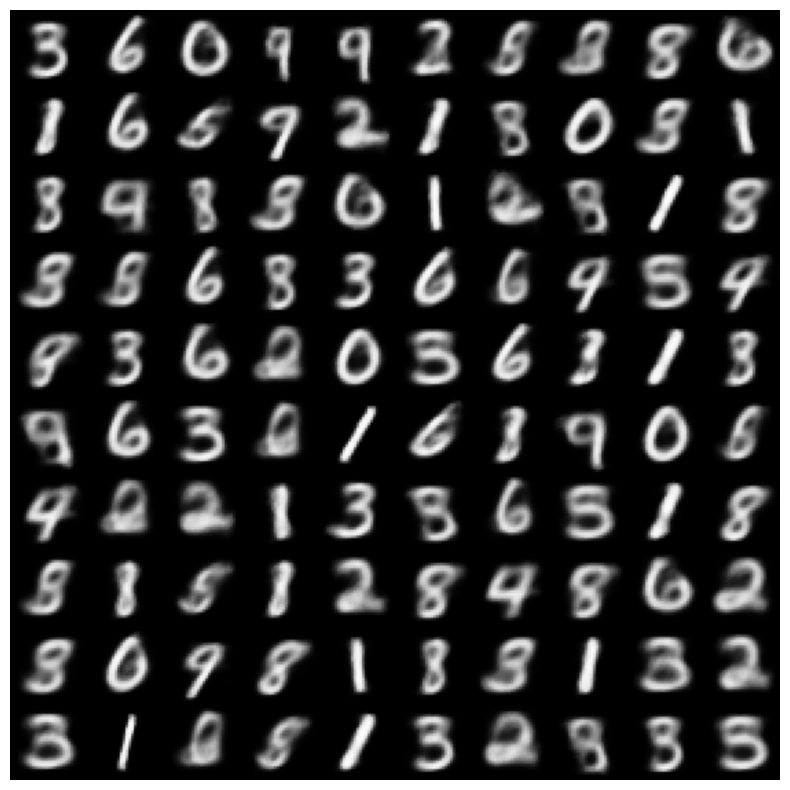

In [26]:
n = 10
latent_dim = 2
z = torch.randn(n * n, latent_dim)  # Sample z from a standard normal distribution
generated = decoder(z)
imgs = np.zeros((n*28, n*28))

plt.figure(figsize=(10, 10))
for i in range(n*n):
    imgs[i//n  * 28: i//n * 28 + 28,i%n * 28 : i%n * 28 + 28] = 1 - generated[i].detach().numpy().reshape(28,28)
plt.axis('off')
plt.imshow(imgs, cmap='Greys')

## Latent Space Visualization

It is quite useful to visualize the latent space from the variational auto-encoder. You can visualize it either for the training data or the dev data. 

- $\textcolor{red}{\text{Note}}$: If you want to visualize a latent space when its dimension is greater than two (useful for the first part), you could project it in 2 dimensions using PCA (it's already implemented in scikit-learn). 

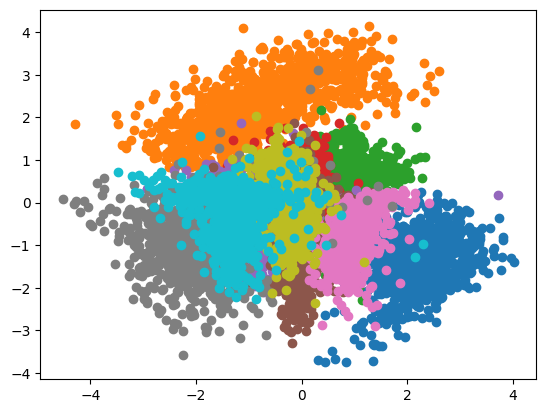

In [27]:
import matplotlib.cm as cm

labels = np.array(dev_data[1])
images = np.array(dev_data[0])
dl = DataLoader(list(zip(images, labels)), batch_size=128, shuffle=True, drop_last=True)
az = []
ay = []
with torch.no_grad():
    for x, y in dl:
        mu, log_sigma = encoder(x)

        z = torch.randn(mu.shape) * torch.exp(0.5 * log_sigma) + mu
        az += z.tolist()
        ay += y.tolist()
az = np.array(az)
ay = np.array(ay)

colors = cm.rainbow(np.linspace(0, 1, 10))
for i in range(10):
    plt.scatter(az[ay == i][:, 0], az[ay == i][:, 1])

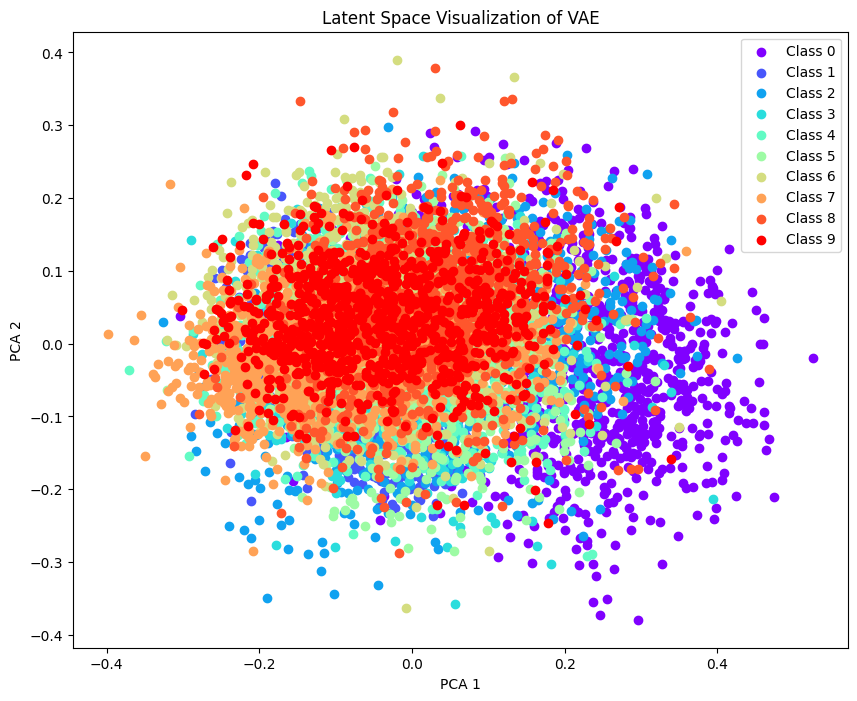

In [30]:
# Loading the Data
mnist_path = "./mnist.pkl.gz"
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

# Preprocessing data
dev_images = np.array(dev_data[0], dtype=np.float32).reshape(-1, 28, 28)  # Ensure images are 28x28 in shape
dev_labels = np.array(dev_data[1])

# Transforming the Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dev_dataset = [(transform(img), label) for img, label in zip(dev_images, dev_labels)]
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=True, drop_last=True)

# Model definition
encoder = VAEEncoder(784,400, 2)
decoder = VAEDecoder(2,400,784)

# To collect latent variables and labels
latent_variables = []
labels = []

encoder.eval()
with torch.no_grad():
    for data, label in dev_loader:
        data = data.view(-1, 784)  # To ensure input data is the correct shape
        mu, log_var = encoder(data)
        latent_variables.extend(mu.numpy())
        labels.extend(label.numpy())

latent_variables = np.array(latent_variables)
labels = np.array(labels)

# Using PCA for dimension reduction with two principal components for visualization.
pca = PCA(n_components=2)
latent_variables_pca = pca.fit_transform(latent_variables)

# Visualization
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(latent_variables_pca[labels == i][:, 0], latent_variables_pca[labels == i][:, 1], color=colors[i], label=f'Class {i}')
plt.title('Latent Space Visualization of VAE')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()